Dataset: [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

In [1]:
import random
from PIL import Image
from datetime import datetime
import unicodedata
import numpy as np
import pandas as pd
import nltk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
sns.set()
# Chọn các màu sắc
COLOR_5S = '#1f77b4'  # Xanh dương
COLOR_1S = '#d62728'  # Đỏ
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#ff7f0e', '#2ca02c', '#9467bd', COLOR_5S))
# Thiết lập nền của biểu đồ
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
# Đặt kích thước mặc định của biểu đồ
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [3]:
# Đọc dữ liệu từ tập tin CSV và lưu vào DataFrame
orders = pd.read_csv('dataset/olist_orders_dataset.csv')
reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')

# Chuyển đổi các cột chứa ngày tháng trong DataFrame 'reviews' sang định dạng datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], format='ISO8601')
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], format='ISO8601')

# Chuyển đổi các cột chứa ngày tháng trong DataFrame 'orders' sang định dạng datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='ISO8601')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='ISO8601')


# Kết hợp hai DataFrame 'reviews' và 'orders' dựa trên cột 'order_id'
reviews = pd.merge(reviews, orders, on='order_id')

# Loại bỏ các cột không cần thiết từ DataFrame 'reviews'
to_drop = [
    'review_id',
    'order_id',
    'customer_id',
    'review_comment_title',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)

In [4]:
reviews.head()

,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date
0,4,NaN,2018-01-18,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-17 18:42:41
1,5,NaN,2018-03-10,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-03-09 23:17:20
2,5,NaN,2018-02-17,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-16 17:28:48
3,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35


In [5]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print(len(reviews), 'reviews')
print('First:', first_dt)
print('Last:', last_dt)
print(f'5★: {p_5s:.1f}%')
print(f'1★: {p_1s:.1f}%')
print(f'Average: {avg_s:.1f}★')

99224 reviews
First: 2016-10-02 00:00:00
Last: 2018-08-31 00:00:00
5★: 57.8%
1★: 11.5%
Average: 4.1★


DataFrame của chúng ta có 100.000 đánh giá, với mức đánh giá trung bình là 4.1 sao.

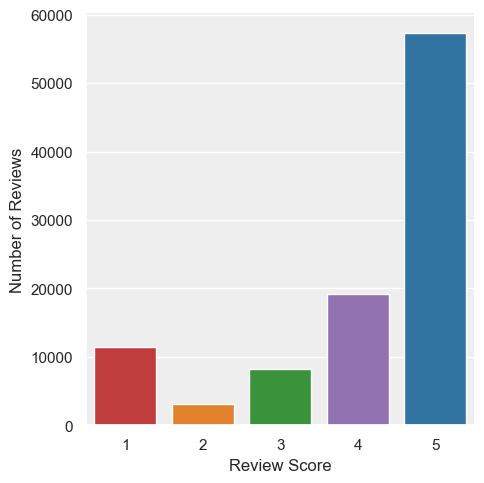

In [6]:
sns.catplot(
    x='review_score',
    kind='count',
    data=reviews,
    hue='review_score',
    palette=REVIEWS_PALETTE,
    legend=False
).set(
    xlabel='Review Score',
    ylabel='Number of Reviews',
);

Ở đây chúng ta có thể thấy phân phối của các điểm đánh giá. Quan sát ta thấy rằng đánh giá 1 sao nhiều hơn tổng đánh giá 2 và 3 sao

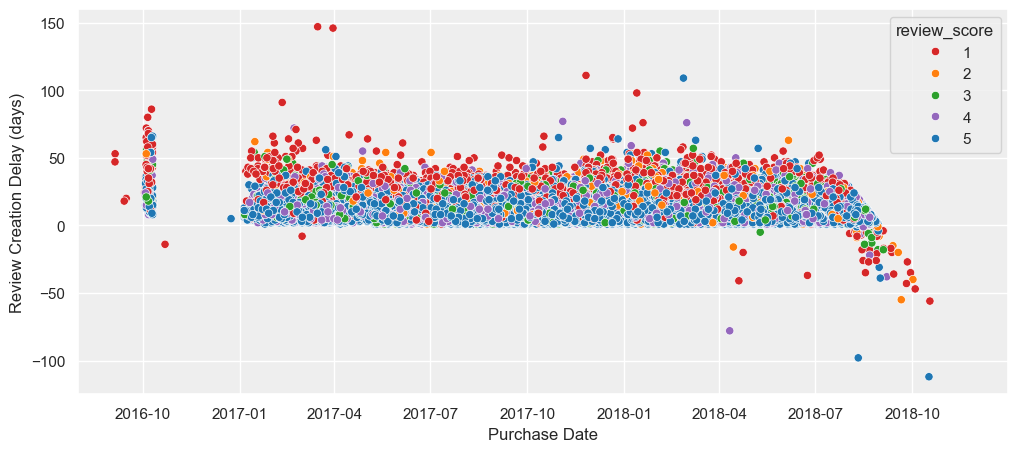

In [7]:
reviews['review_creation_delay'] = (reviews['review_creation_date'] - reviews['order_purchase_timestamp']).dt.days
sns.scatterplot(
    x='order_purchase_timestamp',
    y='review_creation_delay',
    hue='review_score',
    palette= REVIEWS_PALETTE,
    data=reviews
).set(
    xlabel='Purchase Date',
    ylabel='Review Creation Delay (days)',
    xlim=(datetime(2016, 8, 1), datetime(2018, 12, 31))
);
resize_plot()

Chúng tôi muốn rằng các đánh giá được tạo ra sau khi các giao dịch mua hàng tương ứng được thực hiện, nhưng tập dữ liệu có một số giá trị âm cho độ trễ trong việc tạo đánh giá (có nghĩa là các đánh giá được gửi đến khách hàng trước khi mua hàng xảy ra)

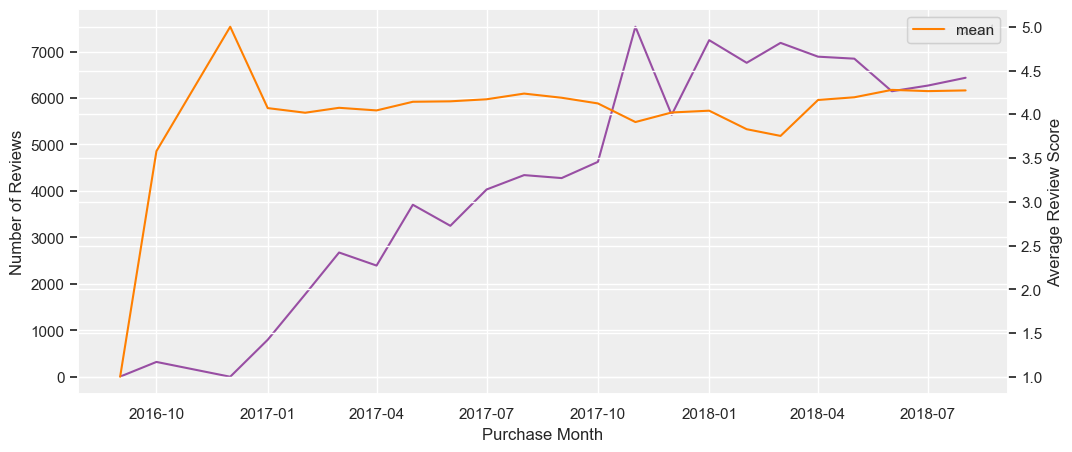

In [8]:
reviews['year_month'] = reviews['order_purchase_timestamp'].dt.to_period('M')
reviews_timeseries = reviews[reviews['review_creation_delay'] > 0].groupby('year_month')['review_score'].agg(['count', 'mean'])

ax = sns.lineplot(
    x=reviews_timeseries.index.to_timestamp(),
    y='count',
    data=reviews_timeseries,
    color='#984ea3',
    label='count'
)
ax.set(xlabel='Purchase Month', ylabel='Number of Reviews')

sns.lineplot(
    x=reviews_timeseries.index.to_timestamp(),
    y='mean',
    data=reviews_timeseries,
    ax=ax.twinx(),
    color='#ff7f00',
    label='mean'
).set(ylabel='Average Review Score');
resize_plot()

Chúng ta đang thực hiện việc nhóm các đánh giá theo tháng bằng cách sử dụng cột thời gian mua hàng và vẽ biểu đồ chuỗi thời gian tương ứng.

Ta chỉ xem xét các đánh giá được tạo ra sau thời điểm mua hàng - nếu không, có thể xuất hiện các mẫu lạ trên biểu đồ.

In [9]:
reviews.groupby('order_status')['order_status'].count()

order_status
approved           2
canceled         609
created            3
delivered      96361
invoiced         313
processing       296
shipped         1043
unavailable      597
Name: order_status, dtype: int64

Tiếp theo, chúng ta sẽ kiểm tra các đánh giá bằng cách kiểm tra tình trạng đơn hàng của chúng.

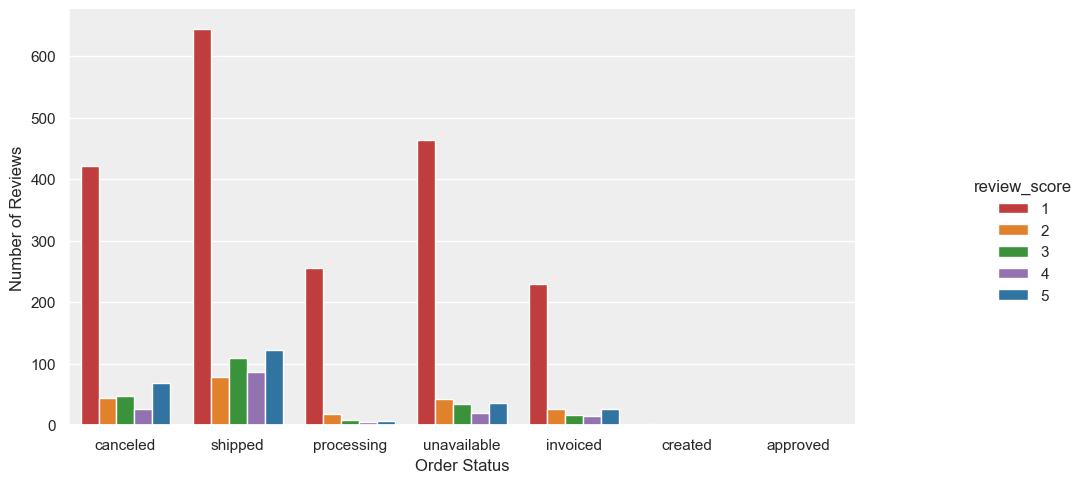

In [10]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=reviews[reviews['order_status'] != 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Order Status', ylabel='Number of Reviews');
resize_plot()

Nếu vẽ biểu đồ phân phối điểm đánh giá của các đơn hàng không có tình trạng 'đã giao', có thể thấy rằng hầu hết chúng có đánh giá 1 sao.

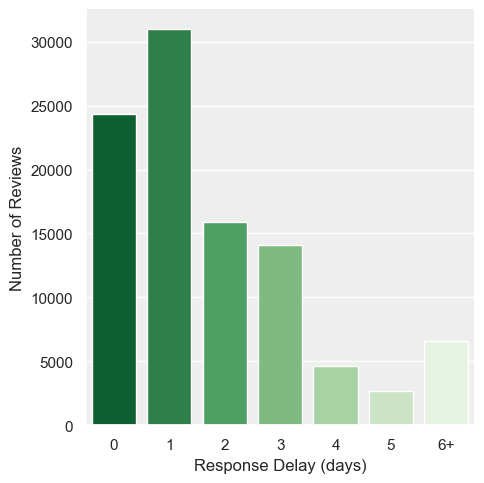

In [11]:
reviews['delay'] = (reviews['review_answer_timestamp'] - reviews['review_creation_date']).dt.days

bins = [-1, 0, 1, 2, 3, 4, 5, 99999]
labels = ['0', '1', '2', '3', '4', '5', '6+']
reviews['delay_group'] = pd.cut(reviews['delay'], bins, labels=labels)

sns.catplot(
    x='delay_group',
    kind='count',
    data=reviews,
    hue='delay_group',
    palette=sns.color_palette('Greens_r', n_colors=7),
    legend=False
).set(xlabel='Response Delay (days)', ylabel='Number of Reviews');

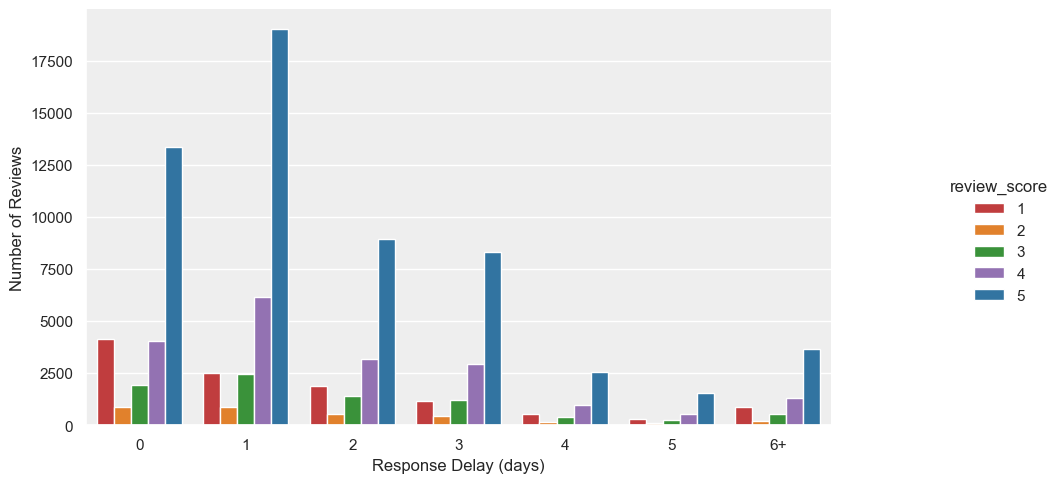

In [12]:
sns.catplot(
    x='delay_group',
    kind='count',
    hue='review_score',
    data=reviews,
    palette=REVIEWS_PALETTE
).set(xlabel='Response Delay (days)', ylabel='Number of Reviews');
resize_plot()

Xu hướng là các khách hàng không hài lòng (đánh giá 1 sao) thường trả lời khảo sát vào cùng một ngày, trong khi hầu hết các khách hàng khác thường đợi ít nhất một ngày trước khi trả lời.

In [13]:
reviews['review_length'] = reviews['review_comment_message'].str.len()
reviews[['review_score', 'review_length', 'review_comment_message']].head()

,review_score,review_length,review_comment_message
0,4,NaN,NaN
1,5,NaN,NaN
2,5,NaN,NaN
3,5,37.0,Recebi bem antes do prazo estipulado.
4,5,100.0,Parabéns lojas lannister adorei comprar pela I...


Mặc dù đã phân tích tương đối về các đánh giá, nhưng vẫn còn biết khá ít về những gì khách hàng thích và không thích nhất về trải nghiệm.


Ta sẽ bắt đầu nghĩ đến việc sử dụng các bình luận đánh giá.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28492\271856724.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_rates = reviews.groupby('review_score').apply(comment_rate).reset_index(name='comment_rate')


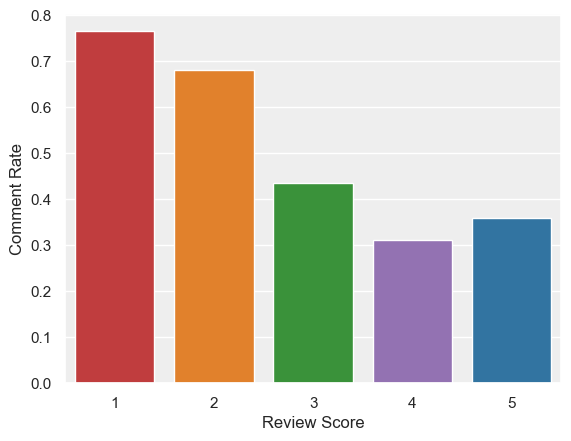

In [14]:
def comment_rate(df):
    return df['review_length'].count() / len(df)

comment_rates = reviews.groupby('review_score').apply(comment_rate).reset_index(name='comment_rate')
sns.barplot(
    x='review_score',
    y='comment_rate',
    data=comment_rates,
    hue='review_score',
    palette=REVIEWS_PALETTE,
    legend=False
).set(xlabel='Review Score', ylabel='Comment Rate');

Tỉ lệ bình luận được định nghĩa là số lượng bình luận không rỗng (không phải NaN) chia cho tổng số lượng đánh giá.

Đây là một phép đo cho biết tỷ lệ các đánh giá được kèm theo bình luận so với tổng số lượng đánh giá.

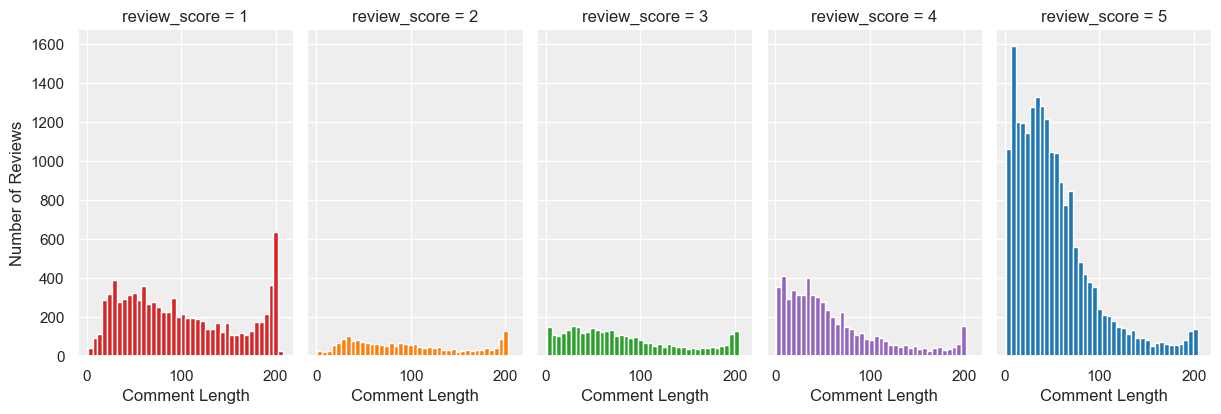

In [15]:
g = sns.FacetGrid(data=reviews, col='review_score', hue='review_score', palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12, 5)

Có vẻ khách hàng không hài lòng có xu hướng sẽ bình luận đánh giá.
Chúng ta có thể thấy rằng họ viết bình luận dài hơn.


In [16]:
import unicodedata
import nltk
nltk.download('stopwords')



def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))

    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    resize_plot()
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Đoạn mã trên loại bỏ dấu và loại bỏ từ dừng từ trong văn bản tiếng Bồ Đào Nha.

In [17]:
import nltk
nltk.download('punkt')


commented_reviews = reviews[reviews['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Bây giờ chúng ta đã có một bộ công cụ NLP cơ bản, chúng ta có thể sử dụng nó để phân tích các đánh giá 1 sao và 5 sao.

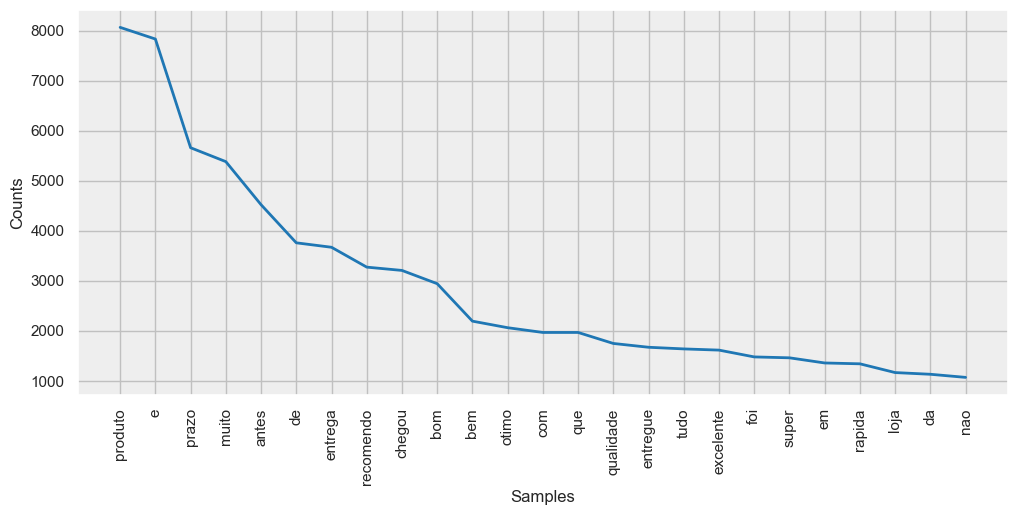

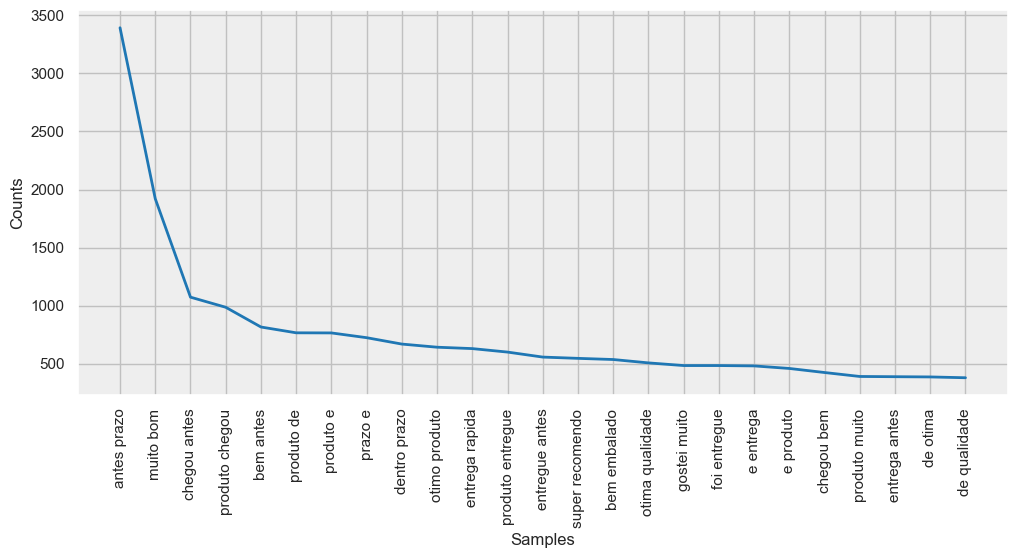

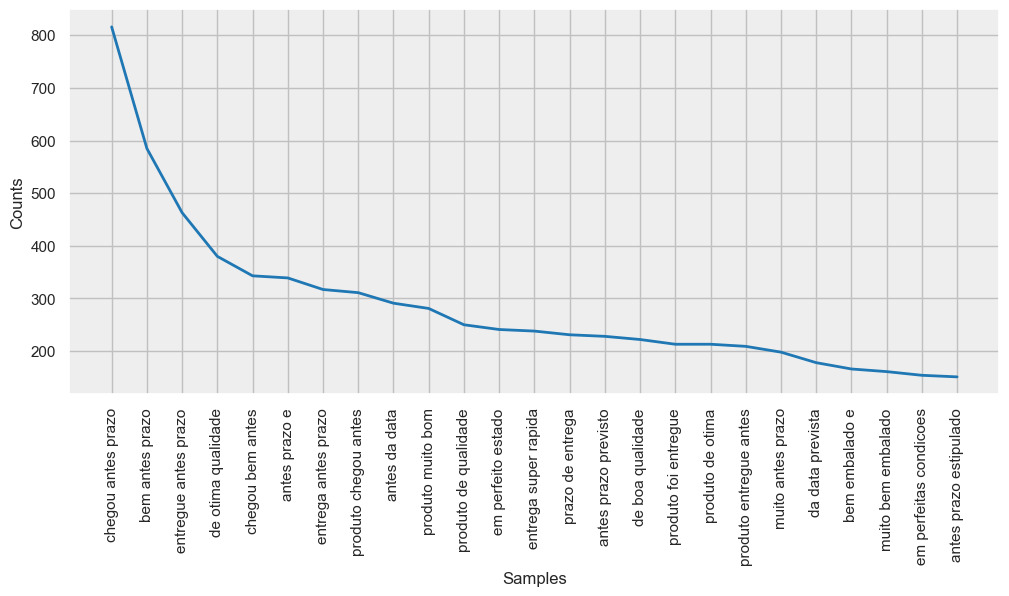

In [18]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)

Dưới đây là phân phối tần suất cho các n-grams 5 sao.

Ta có thể xác định một số chủ đề chính mà khách hàng thích về trải nghiệm:
* Giao hàng nhanh chóng ('chegou antes prazo', 'entrega rapida', 'entregue antes prazo', 'super rapida')
* Hàng hóa chất lượng cao ('produto otima qualidade', 'otimo produto', 'produto excelente', 'produto boa qualidade')
* Đóng gói tốt ('bem embalado', 'produto chegou bem')

Điều này cho thấy rằng các khách hàng đánh giá cao việc giao hàng nhanh chóng, chất lượng hàng hóa và đóng gói cẩn thận.

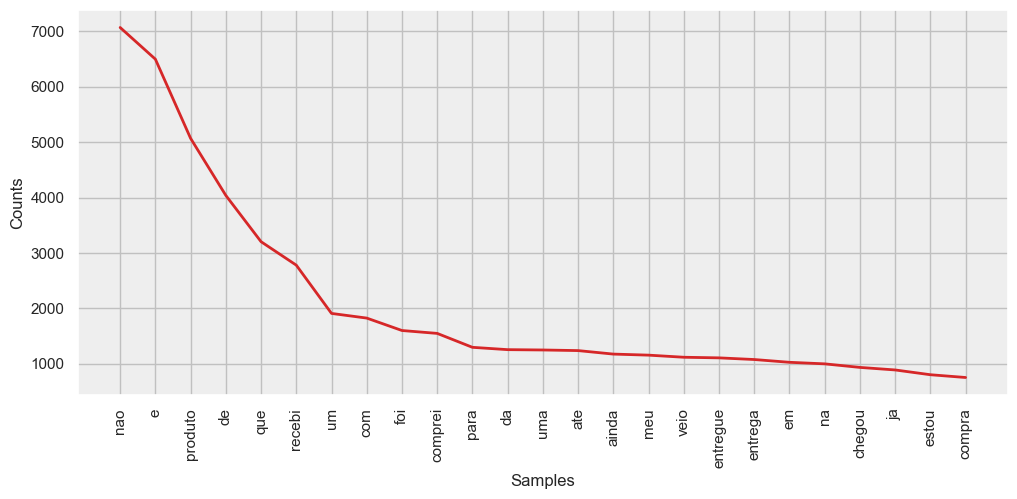

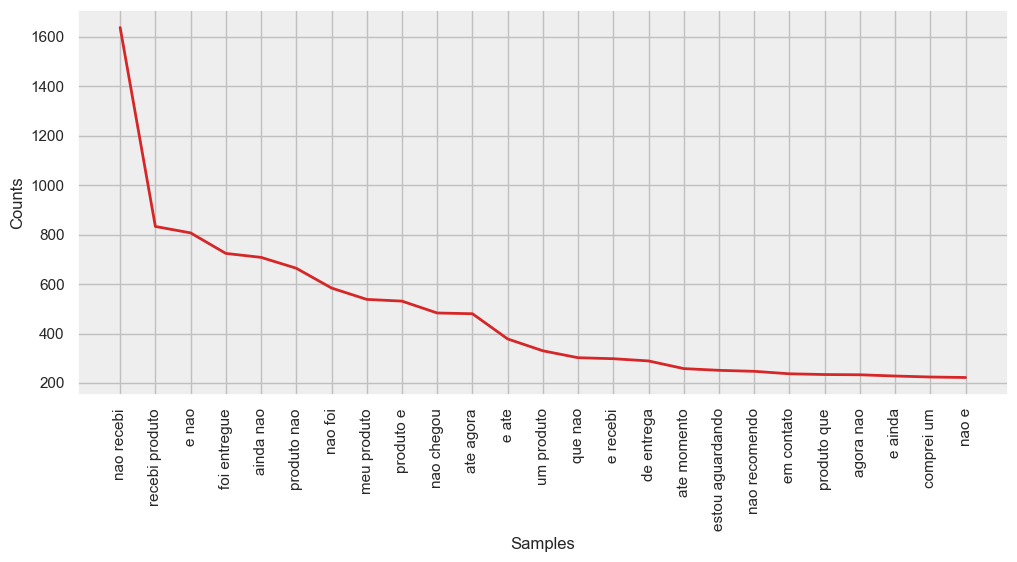

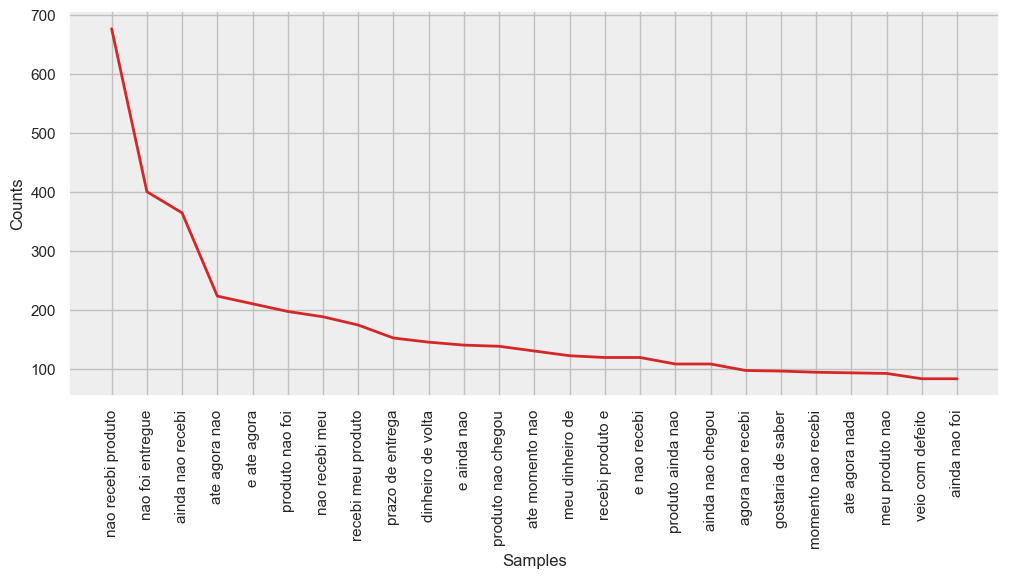

In [19]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)

Dưới đây là phân phối tần suất cho các n-grams 1 sao. Chúng ta có thể xác định một số chủ đề chính mà khách hàng không hài lòng về trải nghiệm của họ:
* Họ chưa nhận được hàng của mình ('recebi produto', 'ainda nao recebi', 'produto nao entregue', 'produto nao chegou', 'nao recebi mercadoria')
* Họ gặp vấn đề liên quan đến hóa đơn của họ ('nota fiscal')
* Họ muốn hoàn tiền ('quero dinheiro volta')
* Hàng hóa chất lượng kém ('produto pessima qualidade', 'produto veio defeito')
* Họ gặp vấn đề khi mua 2 sản phẩm ('comprei dois produtos')
* Trải nghiệm không tốt với cửa hàng Lannister ('lannister')
* Trải nghiệm không tốt với dịch vụ khách hàng, có thể ('contato')

Còn chưa rõ làm thế nào các chủ đề này liên quan đến các đánh giá 1 sao, vì vậy cần phân tích sâu hơn.

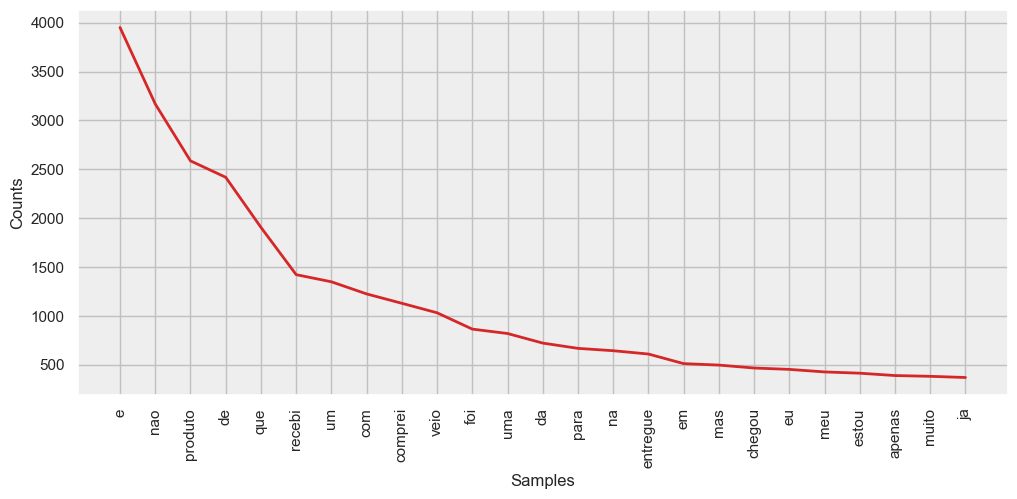

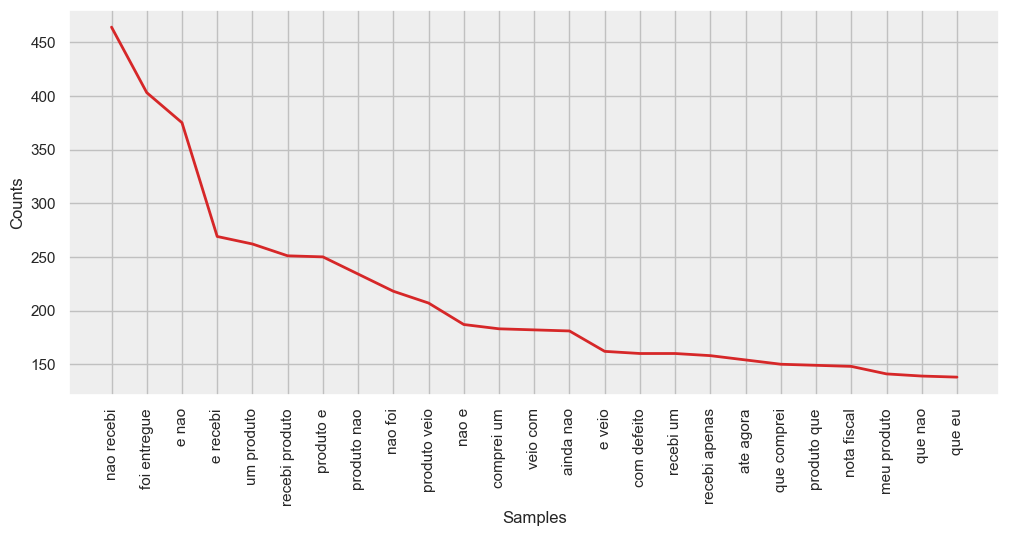

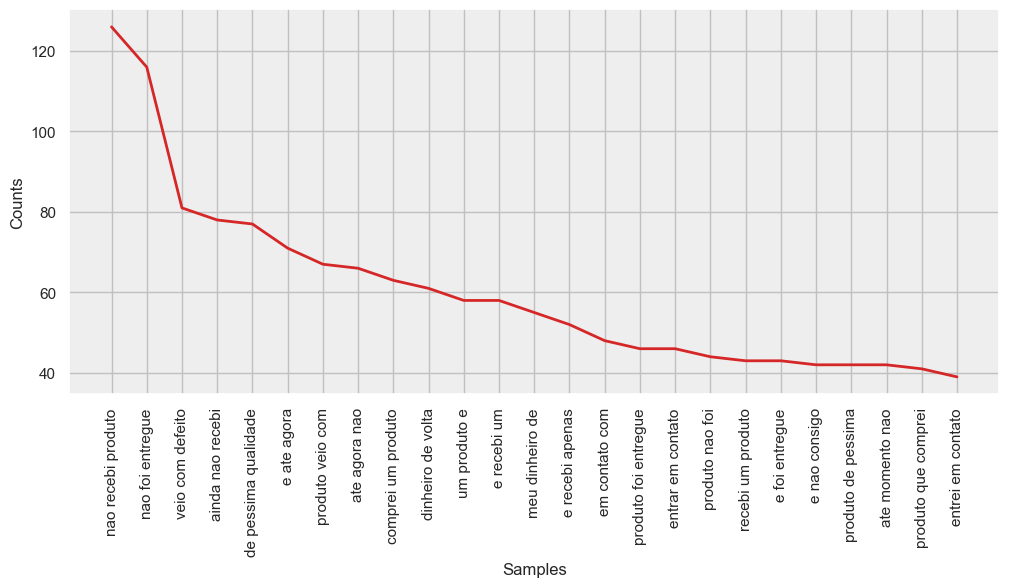

In [20]:
reviews_delivered_1s = commented_reviews[(commented_reviews['review_score'] == 1) & (commented_reviews['order_delivered_customer_date'] < commented_reviews['review_creation_date'])]
unigrams_d1s, bigrams_d1s, trigrams_d1s = words_to_ngrams(reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
plot_freq(bigrams_d1s, COLOR_1S)
plot_freq(trigrams_d1s, COLOR_1S)

Hầu hết các đánh giá 1 sao phàn nàn về việc đơn hàng không được giao, ta có thể lựa chọn các đánh giá được tạo ra sau khi sản phẩm đã được giao. Tuy nhiên, khi đó vẫn còn một số ý kiến về việc giao hàng.
Quan sát các n-grams tương tự như trên, với những chủ đề mới sau:
* Họ nhận được hàng sai ('recebi produto errado', 'produto veio errado', 'produto totalmente diferente')
* Hàng giả ('produto nao original')

Như vậy không chỉ vấn đề liên quan đến việc giao hàng chậm, mà còn có những vấn đề về việc nhận hàng sai hoặc hàng giả trong các đánh giá 1 sao.

In [21]:
def search_words(df, words, n_samples=5, context_character_count=30):
    print(f'Search for "{words.upper()}"')
    words_set = set(words.split(' '))

    # Initial filter
    filtered_df = df[df['review_comment_message'].apply(lambda comment: all(word in comment.lower() for word in words_set))]

    if len(filtered_df) == 0:
        print('> Number of reviews: 0\n')
        return

    # Filter by ordered words
    ordered_words_filter = lambda comment: ' '.join(words.split(' ')) in comment.lower()
    filtered_df = filtered_df[filtered_df['review_comment_message'].apply(ordered_words_filter)]

    if len(filtered_df) == 0:
        print('> Number of reviews: 0\n')
        return

    print(f'> Number of reviews: {len(filtered_df)}')
    avg_rating = filtered_df['review_score'].mean()
    print(f'> Average rating: {avg_rating:.1f}★')

    if n_samples:
        print('> Samples:')
        for _, row in filtered_df.head(n_samples).iterrows():
            comment = row['review_comment_message'].replace('\r', '').replace('\n', '')
            score = row['review_score']
            first_word_index = comment.lower().index(words.split(' ')[0])

            i1 = max(0, first_word_index - context_character_count)
            i2 = min(len(comment), first_word_index + len(words) + context_character_count)
            e1, e2 = '… ' if i1 > 0 else '', ' …' if i2 < len(comment) else ''

            print(f'  {score}★ {e1}{comment[i1:i2]}{e2}')
    print()

Nghiên cứu sâu hơn về các chủ đề này bằng cách phân tích các đánh giá liên quan đến chúng.

Hàm dưới đây để hiển thị một số ví dụ cùng với điểm trung bình của chúng.

In [22]:
search_words(commented_reviews, 'nota fiscal')
search_words(commented_reviews, 'lannister')
search_words(commented_reviews, 'contato')
search_words(commented_reviews, 'original')

Search for "NOTA FISCAL"
> Number of reviews: 378
> Average rating: 2.1★
> Samples:
  1★ … uto desde antes da emissão da nota fiscal. Não fui avisada que estava n …
  1★ Nem fizeram a nota fiscal 
  5★ Apesar da demora em expedir a nota fiscal, depois de expedida a entrega …
  4★ Não veio a nota fiscal
  3★ O produto veio sem nota fiscal, tive que solicitar pelo tele …

Search for "LANNISTER"
> Number of reviews: 1208
> Average rating: 3.2★
> Samples:
  5★ Parabéns lojas lannister adorei comprar pela Internet  …
  5★ Sempre compro na lannister.Pra mim é a melhor loja on-li …
  3★ … do solução por parte de Lojas lannister.
  3★ … ês após a compra. No site das lannister costumam chegar antes do praz …
  3★ … E. Quando tentei reclamar nas lannister o sistema estaav fora do ar.  …

Search for "CONTATO"
> Number of reviews: 563
> Average rating: 1.6★
> Samples:
  3★ … utras 2 quase 48 horas depois.Contato com a loja muito dificil,tant …
  1★ …  o produto, assim como nenhum contato por parte

Ta có thể đưa ra một số kết luận:

* Một số người không nhận được hóa đơn của họ.
* Khách hàng có những đánh giá không liên quan về cửa hàng Lannister.
* Người mua đánh giá thấp dịch vụ khách hàng của người bán, có vẻ như là không phản hồi hay trả lời các thắc mắc.
* Một số khách hàng nhận được các mặt hàng giả mạo.

Sau đây, ta sẽ phát triển mô hình để phán đoán rating dựa trên bình luận.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 'commented_reviews' là DataFrame chứa bình luận và điểm số
# commented_reviews = pd.read_csv('path_to_your_data.csv')

# Lọc và chuẩn bị dữ liệu
filtered_reviews = commented_reviews[commented_reviews['review_comment_message'].str.contains('NOTA FISCAL|LANNISTER|CONTATO|ORIGINAL', case=False, regex=True)]
X = filtered_reviews['review_comment_message']
y = filtered_reviews['review_score']

# Chia dữ liệu để huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trích xuất đặc trưng TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Huấn luyện mô hình SVM
clf = SVC(kernel='linear')
clf.fit(X_train_tfidf, y_train)

# Lấy mẫu bình luận để minh họa dự đoán
sample_comments = X_test.sample(5, random_state=42)
sample_comments_tfidf = vectorizer.transform(sample_comments)

# Dự đoán điểm số
predicted_scores = clf.predict(sample_comments_tfidf)

# In ra kết quả
for comment, predicted in zip(sample_comments, predicted_scores):
    actual_score = y_test.loc[sample_comments.index]
    print(f'Review: {comment}\nPredicted Score: {predicted}\nActual Score: {actual_score}\n')


Review: Absurdo... já acabou o prazo de entrega e o produto nem saiu ainds(a nota fiscal não foi emitida). Agora virou festa: 2 produto q compro e n recebo! o site da stark p mim n é MAIS DE CONFIANÇA!!!!
Predicted Score: 1
Actual Score: 12241    1
35711    1
5820     5
52897    5
79830    5
Name: review_score, dtype: int64

Review: Ainda não recebi o produto no rastreamento fala que eu mudei tô esperando entrar em contato para entender o que que aconteceu
Predicted Score: 1
Actual Score: 12241    1
35711    1
5820     5
52897    5
79830    5
Name: review_score, dtype: int64

Review: lannister é nota 10 sempre.
Predicted Score: 5
Actual Score: 12241    1
35711    1
5820     5
52897    5
79830    5
Name: review_score, dtype: int64

Review: Sou cliente a muito tempo das lojas lannister.
adoro sempre fui muito bem atendida nos prazos e produtos.
Predicted Score: 5
Actual Score: 12241    1
35711    1
5820     5
52897    5
79830    5
Name: review_score, dtype: int64

Review: SÓ UM CONTATO D

Đánh giá mô hình.

In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 'y_test' là nhãn thực và 'y_pred' là nhãn dự đoán của mô hình trên tập kiểm tra
y_pred = clf.predict(X_test_tfidf)

# In báo cáo phân loại với tham số zero_division được thiết lập là 0
print(classification_report(y_test, y_pred, zero_division=0))

# Tính và in độ chính xác
print("Accuracy:", accuracy_score(y_test, y_pred))

# Tạo và in ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

           1       0.62      0.94      0.75       203
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        45
           4       0.33      0.03      0.05        35
           5       0.77      0.86      0.81       150

    accuracy                           0.67       477
   macro avg       0.35      0.37      0.32       477
weighted avg       0.53      0.67      0.58       477

Accuracy: 0.6729559748427673
Confusion Matrix:
 [[191   0   0   0  12]
 [ 42   0   0   1   1]
 [ 34   0   0   0  11]
 [ 19   0   1   1  14]
 [ 20   0   0   1 129]]


* Phân Tích Báo Cáo Phân Loại:
  - Điểm số 1:
    + Precision: 0.62 nghĩa là 62% các dự đoán là 1 sao là chính xác.
    + Recall: 0.94 nghĩa là mô hình đã dự đoán đúng 94% các trường hợp thực tế là 1 sao.
    + F1-Score: 0.75 là trung bình điều hòa của precision và recall, cho thấy hiệu quả tổng thể tốt trong việc nhận diện đánh giá 1 sao.
  - Điểm số 2 và 3:
    Cả hai điểm số này có precision và recall là 0, điều này cho thấy mô hình không dự đoán đúng bất kỳ đánh giá nào là 2 hoặc 3 sao. Điều này là một vấn đề lớn, cho thấy mô hình không hoạt động tốt với các lớp này.
  - Điểm số 4:
    + Precision: 0.33 nghĩa là chỉ có 33% các dự đoán là 4 sao là chính xác.
    + Recall: 0.03, rất thấp, chỉ 3% các trường hợp thực tế là 4 sao được dự đoán chính xác.
  - Điểm số 5:
    + Precision: 0.77 và Recall: 0.86, cả hai chỉ số này khá cao, cho thấy mô hình dự đoán tốt các đánh giá 5 sao.

#### Để xây dựng một mô hình học máy hoàn chỉnh hơn, sử dụng một phương pháp khác như Random Forest hoặc Gradient Boosting

In [25]:
from imblearn.over_sampling import SMOTE

# Áp dụng SMOTE cho tập huấn luyện
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Tạo mô hình Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_res, y_train_res)

# Dự đoán trên tập kiểm tra
y_pred_rf = rf_clf.predict(X_test_tfidf)


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# In báo cáo phân loại và ma trận nhầm lẫn
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


              precision    recall  f1-score   support

           1       0.62      0.94      0.75       203
           2       1.00      0.05      0.09        44
           3       0.50      0.07      0.12        45
           4       0.00      0.00      0.00        35
           5       0.73      0.79      0.76       150

    accuracy                           0.66       477
   macro avg       0.57      0.37      0.34       477
weighted avg       0.64      0.66      0.58       477

Confusion Matrix:
 [[190   0   0   1  12]
 [ 36   2   2   0   4]
 [ 32   0   3   1   9]
 [ 17   0   0   0  18]
 [ 29   0   1   1 119]]


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

# Tạo và huấn luyện mô hình Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train_res, y_train_res)

# Dự đoán và đánh giá
y_pred_gb = gb_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


              precision    recall  f1-score   support

           1       0.68      0.80      0.73       203
           2       0.31      0.09      0.14        44
           3       0.17      0.13      0.15        45
           4       0.07      0.03      0.04        35
           5       0.70      0.81      0.75       150

    accuracy                           0.62       477
   macro avg       0.38      0.37      0.36       477
weighted avg       0.56      0.62      0.58       477

Confusion Matrix:
 [[162   5  13   3  20]
 [ 27   4   9   0   4]
 [ 21   1   6   4  13]
 [ 13   2   3   1  16]
 [ 16   1   4   7 122]]


#### Dựa vào kết quả này, chúng ta có thể đưa ra một số nhận xét:

* Độ chính xác Trung Bình (Accuracy): Độ chính xác tổng thể của mô hình là khoảng 62%, nghĩa là mô hình dự đoán đúng khoảng 62% các điểm đánh giá.
  
* Precision: Đối với các lớp 1 và 5, precision khá cao (68% và 70%), đồng nghĩa với việc mô hình có khả năng dự đoán chính xác các điểm đánh giá là 1 hoặc 5. Tuy nhiên, precision cho các lớp 2, 3 và 4 thấp hơn (từ 7% đến 31%), cho thấy mô hình có xu hướng dự đoán sai nhiều hơn đối với các lớp này.
  
* Recall: Recall cho các lớp 1 và 5 cũng khá cao (từ 80% đến 81%), ngụ ý rằng mô hình có khả năng tìm ra hầu hết các điểm đánh giá thực sự thuộc các lớp này. Tuy nhiên, recall cho các lớp 2, 3 và 4 thấp hơn (từ 3% đến 13%), cho thấy mô hình không phát hiện được nhiều điểm thực sự thuộc các lớp này.
  
* F1-score: F1-score là một phép đo kết hợp giữa precision và recall, có giá trị từ 0 đến 1, và càng cao càng tốt. Đối với các lớp 1 và 5, f1-score khá cao (từ 73% đến 75%), tuy nhiên, nó thấp hơn đối với các lớp 2, 3 và 4 (từ 4% đến 15%).

* Ma Trận Nhầm Lẫn (Confusion Matrix): Ma trận này cho thấy số lượng dự đoán đúng và sai cho mỗi lớp. Các giá trị nằm trên đường chéo chính của ma trận thể hiện số lượng dự đoán đúng cho mỗi lớp, trong khi các giá trị không nằm trên đường chéo chính thể hiện số lượng dự đoán sai.

#### Kết luận: Các mô hình sử dụng còn khá đơn giản, nên độ chính xác tổng thể của mô hình chỉ đạt khoảng 62%, đặc biệt với các trường hợp cụ thể (các đánh giá 2, 3, 4 sao) thì khả năng phán đoán còn thấp.